## StackOverflow Tag Prediction: Multi-label Problem

### Description
* Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and ask doubts.<br>
* Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.


### Problem Statemtent
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

### About Data 
**Train.csv:** contains 4 columns: Id,Title,Body,Tags.

**Test.csv:** contains the same columns but without the Tags, which you are to predict.

**Size of Train.csv:** 6.75GB

**Size of Test.csv:** 2GB

**Number of rows in Train.csv:** 6034195

### Import some important libraries

In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

### 1. Loading Data

In [2]:
# Read data from train.zip with the help of pandas and save it to pandas dataframe
%time main_data = pd.read_csv("../input/facebook-recruiting-iii-keyword-extraction/Train.zip")

CPU times: user 2min 16s, sys: 7.56 s, total: 2min 23s
Wall time: 3min 11s


In [3]:
main_data.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


Let see how our data is looks like

In [4]:
# To check 10th record
print("-------Titles-------\n",main_data["Title"].loc[10])
print("\n-------Body-------\n",main_data["Body"].loc[10])
print("\n-------Tags-------\n",main_data["Tags"].loc[10])

-------Titles-------
 How do commercial obfuscators achieve to crash .net Reflector and ILDASM?

-------Body-------
 <p>Some commercial obfuscators <a href="http://www.remotesoft.com/salamander/obfuscator.html" rel="nofollow">claim they can crash ILDASM</a> (and other similar tools such as Reflector)</p>

<p><strong>Any idea on how they achieve that?</strong></p>

<p>As stated in numerous threads here, someone with enough motivation/time/skill will always find a way to read your code (aka if it's runnable, it's decompilable), but it seems to me that most casual code readers won't bother decompiling my code if Reflector can't do it for them.</p>

<p>This level of protection of my IP (ie, protected against anybody but the hardcore guys who would probably find a way around every single trick I would throw at them anyway) would definitely be enough for me.</p>


-------Tags-------
 .net obfuscation reflector


### 2. EDA: Exploratory Data Analysis

In [5]:
# Check the shape of data with number of row and columns
print("Shape is:-> ",main_data.shape)
print("Number of Rows are: {} \nNumber of Columns are: {}"
      .format(main_data.shape[0],main_data.shape[1]))

Shape is:->  (6034195, 4)
Number of Rows are: 6034195 
Number of Columns are: 4


In [6]:
# Chech all columns name 
print("Name of all coolumns: ",main_data.columns)

Name of all coolumns:  Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')


As we have seen that dataset very large so it took long to to work on it.<br>
**Solution:** 100000 random data points

#### 2.1 Let's check and drop duplicate rows

In [7]:
# To drop duplicate rows based on title, body, and tags
%time main_data = main_data.drop_duplicates(['Title', 'Body', 'Tags'])

CPU times: user 36.2 s, sys: 1 s, total: 37.2 s
Wall time: 37.2 s


In [8]:
# To how much rows and percentage data was duplicated
print("The previous shape of the data was:  (6034195, 4)")
print("Now shape of the data is: ",main_data.shape)
print("Total duplicate rows were {}  means {:.2f}%"
      .format(6034195-main_data.shape[0],((6034195-main_data.shape[0])/6034195)*100))

The previous shape of the data was:  (6034195, 4)
Now shape of the data is:  (4206314, 4)
Total duplicate rows were 1827881  means 30.29%


In [10]:
# To add new columns for tag counts
main_data["tag_count"] = main_data["Tags"].apply(lambda tags: len(str(tags).split(" ")))
main_data.head(3)

,Id,Title,Body,Tags,tag_count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3


In [11]:
# To check how many questions have how many tags
counts = main_data.tag_count.value_counts().to_frame()
counts["tags"] = counts.index
counts.reindex(index=[1,2,3,4,5])

,tag_count,tags
1,568297,1
2,1111706,2
3,1206157,3
4,814996,4
5,505158,5


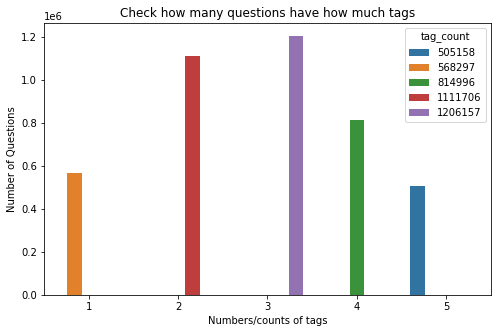

In [12]:
# To plot for a better visualization with seaborn and matplotlib
plt.figure(figsize=(8, 5))
sns.barplot(x="tags", y="tag_count", hue="tag_count", data=counts)
plt.ylabel("Number of Questions")
plt.xlabel("Numbers/counts of tags")
plt.title("Check how many questions have how much tags")
plt.show()

**Observations:**
* Approx 1.2 Million Questions have 3 tags and 1.1 Millions Questions have 2 tags
* Maximum number of questions have 3 tags
* Minimun number of questions have 5 tags
* Minimum number of tags is 1 and maximum is 5

#### 2.2 Tags Analysis

In [13]:
# Initializing the "CountVectorizer" object
#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())

# fit_transform() does
# 1. Fits the model and learns the vocabulary
# 2. Transforms our data into feature vectors as Bag of word
tag_info = vectorizer.fit_transform(main_data['Tags'].values.astype(str))

In [14]:
print("Number of data points :", tag_info.shape[0])
print("Number of unique tags :", tag_info.shape[1])
print("Ten vocabulary names: ",vectorizer.get_feature_names()[:10])

Number of data points : 4206314
Number of unique tags : 42048
Ten vocabulary names:  ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


In [15]:
# tag_info.sum(axis=0) will gives use a numpy.matrix and with A1 we are conveting it to numpy.ndarray
# matrix([[18, 37,  1, ...,  8, 32,  1]])  ---->   array([18, 37,  1, ...,  8, 32,  1])
freq_array = tag_info.sum(axis=0).A1

# To make dictionary
result = dict(zip(vectorizer.get_feature_names(),freq_array))

# To make the dataframe with Dictionary
tag_data = pd.DataFrame(result.items(), columns=["Tags", "tag_frequency"])
tag_data.head(3)

,Tags,tag_frequency
0,.a,18
1,.app,37
2,.asp.net-mvc,1


**Observations:**
* .a tags occurs in 18 questions amongs 4.2 Million questions
* .asp.net-mvc occurs in only 1 question
* NOTE: There is no repeatation of tag in the same question

#### 2.3 Tags Distribution Analysis

In [16]:
# First sort the Tag_data dataframe in descending order to work with 
# it easily on the bases of question_count
sorted_tag_data = tag_data.sort_values(['tag_frequency'], ascending=False)

# Get all question count of a tag from sorted dataframe 
tag_freq = sorted_tag_data['tag_frequency'].values

In [17]:
# After sorting
sorted_tag_data.head()

,Tags,tag_frequency
4337,c#,331505
18069,java,299414
27249,php,284103
18157,javascript,265423
1234,android,235436


In [18]:
# now we get an numpy array
tag_freq

array([331505, 299414, 284103, ...,      1,      1,      1])

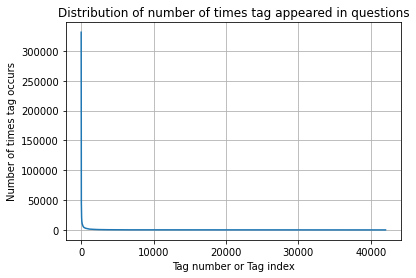

In [19]:
# To plot tag_frequency
plt.plot(tag_freq)
plt.title("Distribution of number of times tag appeared in questions")
plt.grid()
plt.xlabel("Tag number or Tag index")
plt.ylabel("Number of times tag occurs")
plt.show()

**Observations**
* With this plot we did not get much info lets zoom in

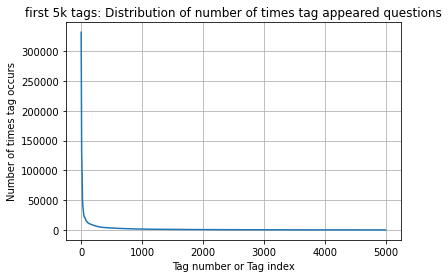

In [20]:
# Take l0000 points to zoom in
plt.plot(tag_freq[0:5000])
plt.title('first 5k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number or Tag index")
plt.ylabel("Number of times tag occurs")
plt.show()

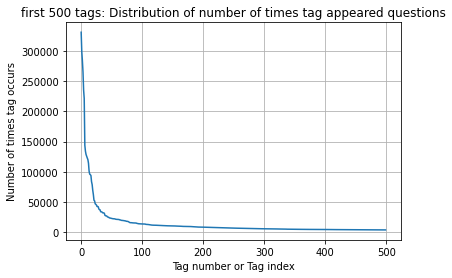

In [21]:
# Take 1000 points to zoom in
plt.plot(tag_freq[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number or Tag index")
plt.ylabel("Number of times tag occurs")
plt.show()

**Observations**
* Now we get some information that out first 200 tags are contributing more

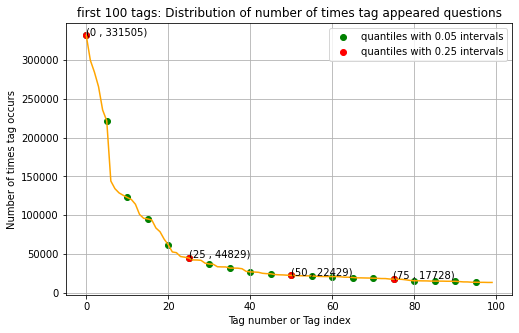

Total Quantiles we plots are:  20
Tag frequency in each 5th Quantile 331505
Tag frequency in each 6th Quantile 221533
Tag frequency in each 7th Quantile 122769
Tag frequency in each 8th Quantile 95160
Tag frequency in each 9th Quantile 62023
Tag frequency in each 10th Quantile 44829
Tag frequency in each 11th Quantile 37170
Tag frequency in each 12th Quantile 31897
Tag frequency in each 13th Quantile 26925
Tag frequency in each 14th Quantile 24537
Tag frequency in each 15th Quantile 22429
Tag frequency in each 16th Quantile 21820
Tag frequency in each 17th Quantile 20957
Tag frequency in each 18th Quantile 19758
Tag frequency in each 19th Quantile 18905
Tag frequency in each 20th Quantile 17728
Tag frequency in each 21th Quantile 15533
Tag frequency in each 22th Quantile 15097
Tag frequency in each 23th Quantile 14884
Tag frequency in each 24th Quantile 13703


In [22]:
# To change the figure size
plt.figure(figsize=(8, 5))

# To plot from 0 to 100 points with orange color
plt.plot(tag_freq[0:100], c='orange')

# plot scatter plot with every 5th percentile 
plt.scatter(x=list(range(0,100,5)), y=tag_freq[0:100:5], c='g', label="quantiles with 0.05 intervals")

# plot scatter plot with every 25th percentile 
plt.scatter(x=list(range(0,100,25)), y=tag_freq[0:100:25], c='r', label = "quantiles with 0.25 intervals")

# Add some annotations in the plot itself
for x,y in zip(list(range(0,100,25)), tag_freq[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number or Tag index")
plt.ylabel("Number of times tag occurs")
plt.legend()
plt.show()
print("Total Quantiles we plots are: ",len(tag_freq[0:100:5]))
for i in enumerate(tag_freq[0:100:5]):
    print("Tag frequency in each {}th Quantile {}".format(i[0]+5,i[1]))

**Observations**
* Dataset of tags is very/Highly Skewed
* There are some tags which occurs very frequently
* There are some tags which occurs very few time

In [23]:
# Tags that occurs greater than 10k times in questions
list_tags_gt_10k = tag_data[tag_data.tag_frequency>10000].Tags

#Print the length of the list
print ('{} Tags are used more than 10k times'.format(len(list_tags_gt_10k)))

# Tags that occurs greater than 100k times in questions
list_tags_gt_100k = tag_data[tag_data.tag_frequency>100000].Tags

#Print the length of the list.
print ('{} Tags are used more than 100k times'.format(len(list_tags_gt_100k)))

153 Tags are used more than 10k times
14 Tags are used more than 100k times


**Observations:**
* There are total 153 tags which are used more than 10000 times.
* 14 tags are used more than 100000 times.
* Most frequent tag (i.e. c#) is used 331505 times.
* Since some tags occur much more frequenctly than others, Then Micro-averaged F1-score is the appropriate metric for this probelm.

#### 2.4 Tags Per Question

In [24]:
#Storing the count of tag in each question in list 'tag_question_count'
tag_question_count = tag_info.sum(axis=1).tolist()

#Converting list of lists into single list, we will get [[5], [1], [3], [3], [3]] 
# and we are converting this to [5, 1, 3, 3, 3] with list comprehension
tag_question_count=[int(j) for i in tag_question_count for j in i]

print ('We have total {} datapoints.'.format(len(tag_question_count)))
print(tag_question_count[:5])

We have total 4206314 datapoints.
[5, 1, 3, 3, 3]


In [25]:
# Let's find some insights
print( "Maximum number of tags per question: %d"%max(tag_question_count))
print( "Minimum number of tags per question: %d"%min(tag_question_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_question_count)*1.0)
                                                /len(tag_question_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899440


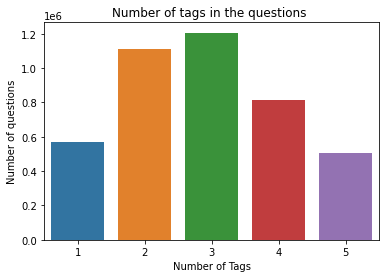

In [26]:
# Let's plot 
sns.countplot(tag_question_count)
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

**Observations:**
* Maximum number of tags per question: 5
* Minimum number of tags per question: 1
* Avg. number of tags per question: 2.899
* Most of the questions are having 2 or 3 tags

#### 2.5 Most Frequent Tags

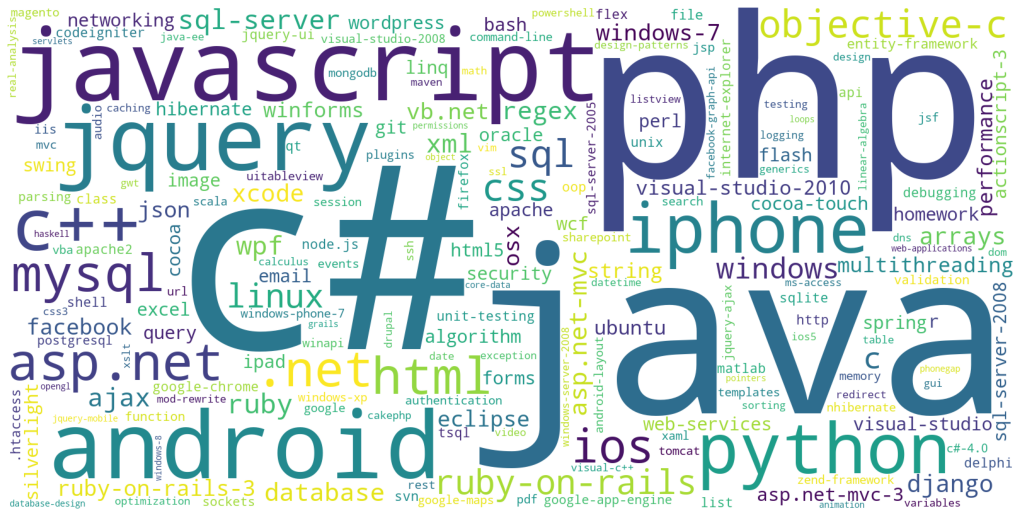

CPU times: user 3.38 s, sys: 195 ms, total: 3.58 s
Wall time: 3.45 s


In [27]:
%%time
# Ploting word cloud

# Lets first convert the 'result' dictionary to 'list of tuples'
# result is : {'.a': 18,'.app': 37,'.asp.net-mvc': 1,'.aspxauth': 21,'.bash-profile': 138}
tag_freq_tuples = dict(result.items())


#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color='white', width=1600, height=800,).generate_from_frequencies(tag_freq_tuples)

fig = plt.figure(figsize=(14,10))

# To show the generated image
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tags.png")
plt.show()

**Observations:**
* A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

#### 2.6 The top 30 Tags

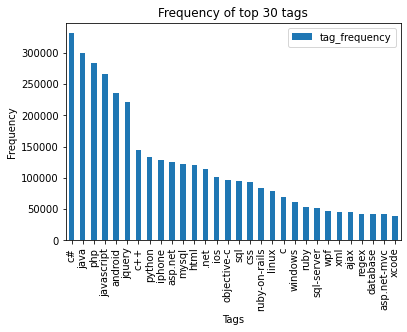

In [28]:
# To generate numbers like from 0 to 29
# [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
i=np.arange(30)

# To plot bar plot
sorted_tag_data.head(30).plot(kind='bar')

plt.title('Frequency of top 30 tags')

# To take the tag names from dataset
plt.xticks(i, sorted_tag_data['Tags'][:30])
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.show()

#### 2.7 Cleaning and preprocessing of Questions
#### 2.7.1 Text preprocessing

In [30]:
# As we discussed earlier our dataset is very big so will work only with 50k Dataset
sample_data = main_data.sample(50000)
sample_data.head(3)

,Id,Title,Body,Tags,tag_count
2907564,2907565,Role provider and System.Web.Security.Roles,<p>I'm confused on how to use roles in my asp....,c# asp.net-mvc-4 authorization,3
1243572,1243573,How to correctly design NoSql database schema?,<p>I would like to learn something more about ...,database-design nosql,2
2260067,2260068,Jquery slide effect only works in my computer,<p>The slide effect only works if I test the f...,javascript jquery webserver slide,4


In [35]:
# To make new datframe for storage of preprocessed data
preprocess_data = pd.DataFrame(columns=['question','code','tags','word_count_before','word_count_after','is_code'])

In [37]:
# This function is very important so please read it carefully
def text_preprocess(sample_data):
    preprocessed_data_list=[]
    questions_with_code=0
    len_before=0
    len_after=0
    counter=0
    # Stopwords are {"the","a","also",etc} they did not contribute any thing then we will delete them
    stop_words = set(stopwords.words('english'))

    # Stemmer is converting like: eating --> eat or running --> run
    stemmer = SnowballStemmer("english")
    
    for row in tqdm(sample_data.iterrows()):
        
        # Extract title, question, and tags from each row
        title, question, tags = row[1][1], row[1][2], row[1][3]
        
        code_flag = 0
        
        # Check if there is any code in the question then make code flag 1
        # Increase question  with code count to see how many question we have with code
        if '<code>' in question:
            questions_with_code += 1
            code_flag = 1
            
        # Add title and question length to see how much we will changed it
        question_before_length = len(question)+len(title)
        len_before += question_before_length
        
        # To extract all code from <code></code> tags and convert it into string
        code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
        
        # To replace <code>...</code> with space " "
        question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
        
        # To remove all HTML tags from questions
        html_cleaner = re.compile('<.*?>')
        question = re.sub(html_cleaner, ' ', str(question.encode("utf-8")))
        
        title=title.encode('utf-8')
        
        # Concatinate title and question
        question=str(title)+" "+str(question)
        
        # To remove all characters instead of alphabets
        question=re.sub(r'[^A-Za-z]+',' ',question)
        
        # First, we convert all text to lowercase and Word tokenize will convert 
        # "This is data preprocessing" --> ["This","is","data","preprocessing"]
        words=word_tokenize(str(question.lower()))
        
        # Removing all single letter and stopwords from question except letter 'c' because c is a prog. language
        # After removing all single words join then with space
        question= ' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
        
        len_after += len(question)
        
        # Append new datapoint to the dataframe
        preprocess_data.loc[len(preprocess_data.index)] = [question,code,tags,question_before_length,len(question),code_flag]
        counter += 1 
        
        # END OF THE FOR LOOP
    
    # To print some insights 
    print( "Avg. length of questions(Title+Body) before processing: ",(len_before*1.0)/counter)
    print( "Avg. length of questions(Title+Body) after processing: ",(len_after*1.0)/counter)
    print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/counter))    

In [38]:
# To preprocess data with text_preprocess function we have defined earlier
%time text_preprocess(sample_data)

50000it [16:53, 49.34it/s] 

Avg. length of questions(Title+Body) before processing:  1177.6273
Avg. length of questions(Title+Body) after processing:  327.88288
Percent of questions containing code: 57
CPU times: user 16min 56s, sys: 4 s, total: 17min
Wall time: 16min 53s


In [39]:
# New preprocessed data
preprocess_data.head()

,question,code,tags,word_count_before,word_count_after,is_code
0,role provid system web secur role confus use r...,"['[Authorize(Roles = ""administrator"")]\npublic...",c# asp.net-mvc-4 authorization,4370,455,1
1,correct design nosql databas schema would like...,[],database-design nosql,417,263,0
2,jqueri slide effect work comput slide effect w...,"['&lt;script src=""http://code.jquery.com/jquer...",javascript jquery webserver slide,823,186,1
3,symbol link text editor sublim mac follow alon...,"['ln -s ""/Applications/Sublime Text 2.app/Cont...",osx sublime-text-2,883,269,1
4,data databas java string data view sql develop...,"['introduction\ntopic 1\n\ntopic end\n', 'Resu...",java jsp resultset,581,125,1


In [40]:
# Let see questions now
for i in preprocess_data["question"].iloc[:3]:
    print("=====================================")
    print(i)

role provid system web secur role confus use role asp net mvc razor project nwhat differ two main use author attribut make check role authent user goe custom role provid mix thing concret admin control user role administr crud stuff nin control appli follow attribut correct assum author attribut use custom role provid back end work part custom role provid class incorrect user correct authent like check author custom role provid edit web config edit ii
correct design nosql databas schema would like learn someth nosql databas chosen creat new project scratch handl footbal result tradit relat databas tournament team result class tabl obvious relat might good approach design project like use nosql approach instead
jqueri slide effect work comput slide effect work test file comput put linux cpanel host work pleas note js file extern jqueri server dont know wrong somebodi help use chrome jqueri html


### 3 Machine learnign modeling

#### 3.1 Covert tags for Multi-label Classification

In [41]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda text: text.split(), binary=True)
 
multi_label_y = vectorizer.fit_transform(preprocess_data['tags'].values.astype(str))

Here y1, y2, y3, y4 we can consider as tags and x1, x2, x3 are as datapoints

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x2</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x3</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table> 

In [42]:
# make sum column wise
tag_column_sum = multi_label_y.sum(axis=0).tolist()[0]

From
<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x2</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x3</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table> 
To
<table>
<tr>
<th></th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>tag_column_sum</td><td>1</td><td>2</td><td>1</td><td>0</td>
</tr>
</table>
As we can see in the above diagram:<br>
we get tag_column_sum after column wise sum of the vectors we made with the help of countvectorizer for tags in last cell

In [46]:
# To select n number of top tags
def select_top_tags(n):
    
    # To get sotred list's index (means: tags appear in maximum number of questions come first)
    # top 10 tag's index: [3711, 15246, 22934, 15324, 1054, 15713, 3720, 24481, 14905, 1897]
    sorted_tags = sorted(range(len(tag_column_sum)), key=lambda i: tag_column_sum[i], reverse=True)
    
    # With this line of code we get tags in our columns which are come in most of the questions
    # we will get shape: (999999, n)
    multi_label_n_y = multi_label_y[:,sorted_tags[:n]]
    return multi_label_n_y

def questions_covered_fn(n):
    multi_label_n_y = select_top_tags(n)
    
    # This line will give us row wise sum of each row  [[1, 2],           [[3],
    #                                                   [4, 3]]     to     [7]]
    row_sum_array = multi_label_n_y.sum(axis=1)

    # Counts the number of non-zero values in the array
    return (np.count_nonzero(row_sum_array==0))

# With this code we checking how much percent questions are explained by how many tags
# Here we are starting from 500 because we think top 500 are most important tags we can't skip them
questions_covered=[]
total_tags=multi_label_y.shape[1]
total_qs=preprocess_data.shape[0]
for i in range(500, total_tags, 100):
    questions_covered.append(np.round(((total_qs-questions_covered_fn(i))/total_qs)*100,3))

Les't Plot to see it visually what we have done in last few cells

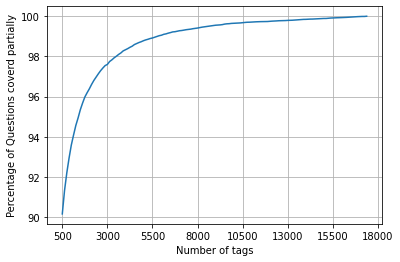

with  5500 tags we are covering  99.222 % of questions


In [47]:
fig, ax = plt.subplots()
ax.plot(questions_covered)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Percentage of Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_covered[50],"% of questions")

In [48]:
multi_label_n_y = select_top_tags(5500)
print("number of questions that are not covered :", questions_covered_fn(5500),"out of ", total_qs)

number of questions that are not covered : 389 out of  50000


In [49]:
print("Number of tags in sample :", multi_label_y.shape[1])
print("number of tags taken :", multi_label_n_y.shape[1],"-->",round((multi_label_n_y.shape[1]/multi_label_y.shape[1]),3)*100,"%")

Number of tags in sample : 14092
number of tags taken : 5500 --> 39.0 %


We consider top 15% tags which covers 99% of the questions

#### 3.2 Split the data into train-80% and test-20% 

In [50]:
total_size=preprocess_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocess_data.head(train_size)
x_test=preprocess_data.tail(total_size - train_size)

# we will get shape: (799999, 5500)
y_train = multi_label_n_y[0:train_size,:]
y_test = multi_label_n_y[train_size:total_size,:]

#### 3.3 Text data Featurization

In [51]:
def text_splitter(text):
    return text.split()

In [53]:
%%time
# To get new features with tfidf technique get 200000 features with upto 3-grams
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = text_splitter, sublinear_tf=False, ngram_range=(1,3))

# Apply this vectorizer only on question data column
x_train_multi_label = vectorizer.fit_transform(x_train['question'])
x_test_multi_label = vectorizer.transform(x_test['question'])

CPU times: user 24.9 s, sys: 1.35 s, total: 26.2 s
Wall time: 26.2 s


In [54]:
# Now check data shapes after featurization
print("Dimensions of train data X:",x_train_multi_label.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multi_label.shape,"Y:",y_test.shape)

Dimensions of train data X: (40000, 105748) Y : (40000, 5500)
Dimensions of test data X: (10000, 105748) Y: (10000, 5500)


In [55]:
x_train_multi_label.shape

(40000, 105748)

#### 3.4 Logistic Regression with OneVsRest Classifier 

In [56]:
%%time
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multi_label, y_train)
predictions = classifier.predict(x_test_multi_label)

CPU times: user 41.3 s, sys: 7.46 s, total: 48.8 s
Wall time: 13min


In [57]:
print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))

accuracy : 0.0739
macro f1 score : 0.0656646827328876
micro f1 scoore : 0.35936476751800916
hamming loss : 0.0004268727272727273


We train this model only on the 50000 data points if we train it more data then we can get more accuracy.
## Thanks For Reading